## Setup autoreload, warnings and helper functions

In [59]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, Markdown
def print_heading(string):
    display(Markdown(f"# {string}"))
def print_subheading(string):
    display(Markdown(f"## {string}"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set the visibility of cuda devices (in case your system contains more than one)

In [60]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


## Imports

In [61]:
%matplotlib inline
from config import config
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import zipfile
import tensorflow as tf
import wget
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from torchvision.datasets.utils import download_url
from datasets import COCOImageDataset, DatasetSlice, SequenceDataset, SimpleDataset

from tools import apply_pipeline, crop_step, curry, apply_pipeline_cocodataset, get_save_step, read_image
from sql import get_db_ids
from tonemapping.tonemapping import tonemap, tonemap_step
from segmentation.segmentation import segment
from pattern_extraction.extract_pattern import extract_pattern
from reidentification.identify import encode_single, encode_pipeline, create_database, identify, identify_single, encode_sequence_dataset, encode_dataset
from reidentification.visualisation import visualise_match
from simple_database import SimpleDatabase, DBDatabase

## Create a configuration file.
You can change the default parameters in config.py

In [80]:
cfg = config()


/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:71: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.9)
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:73: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)
/ekaterina/env/norppa/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Download the dataset

In [63]:
cfg["dataset_dir"] = "/ekaterina/work/data/many_dataset/original_small"
dataset_dir = Path(cfg["dataset_dir"])

if not dataset_dir.exists():
    
    print("Download and extract dataset")
    # Get a single use download link from https://etsin.fairdata.fi/dataset/22b5191e-f24b-4457-93d3-95797c900fc0/data
    # You will only need "full images.zip" for the reidentification, generate a link to that.
    dataset_url = ""
    
    print(f'Creating directory "{dataset_dir}"')
    dataset_dir.mkdir(parents=True, exist_ok=True)
    
    file = wget.download(dataset_url.replace(" ", "%20"), out=str(dataset_dir))
    print()
    print(f'Extracting "{file}"')
    zip_f = zipfile.ZipFile(file, 'r')
    zip_f.extractall(dataset_dir)
    zip_f.close()
    Path(file).unlink()

print(f'SealID dataset is ready')

SealID dataset is ready


## Create dataset variables

In [64]:
dataset_dir = Path(cfg["dataset_dir"])

pattern_query_dataset = SimpleDataset(dataset_dir)

# sequence_ids = pattern_query_dataset.get_sequence_ids()
# print(len(sequence_ids))
# sequence_data = pattern_query_dataset[4]
# print(sequence_data)




## Show an image from the dataset

# Input image

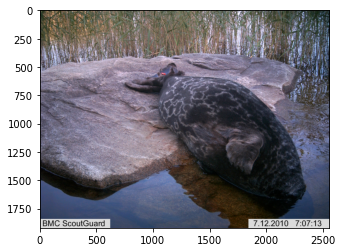

In [65]:
img, label = pattern_query_dataset[0]

print_heading("Input image")
plt.imshow(image)
plt.show()

## Apply tonemapping

completed 100%


# Tonemapped image

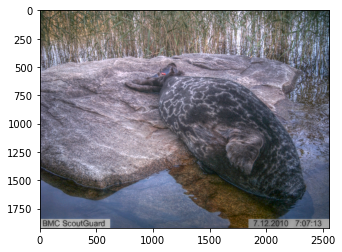

In [74]:
# Remember to install pfstmo package with
# sudo apt-get install pfstmo

tonemapped_img = tonemap(img)

print_heading("Tonemapped image")
plt.imshow(tonemapped_img)
plt.show()

## Segment and crop an image

/ekaterina/env/norppa/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


# Segmented image

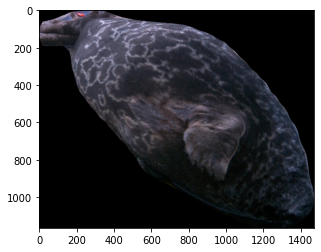

In [75]:
segment_step = curry(segment, cfg["detectron_predictor"], instance_segmentation=False)

segmented_img, label = apply_pipeline(img, label, [segment_step, crop_step])[0]

print_heading("Segmented image")
plt.imshow(segmented_img)
plt.show()

## Extract pattern from an image

# Pattern image

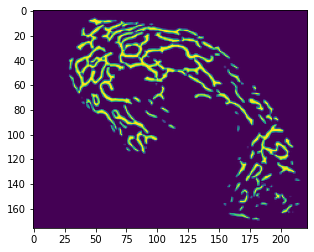

In [76]:
extract_pattern_step = curry(extract_pattern, model=cfg["unet"])

pattern_img, label = apply_pipeline(segmented_img, label, [extract_pattern_step])[0]

print_heading("Pattern image")
plt.imshow(pattern_img)
plt.show()

## Encode an image

In [107]:
encoded_img = encode_single(pattern_img, cfg)
print("Encoded image")


  0%|                                                     | 0/1 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]

Calculating PCA
Getting encoding parameters...
Encoding...
1
Encoded image


In [111]:

from torchvision import transforms

dataset_transforms = transforms.Grayscale(num_output_channels=1)
encoded_dataset = encode_dataset([(dataset_transforms(image), 0)], cfg)


  0%|                                                     | 0/1 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


Calculating PCA
Getting encoding parameters...
Encoding...


((array([-1.65844231e-05,  6.35799443e-05, -4.35146467e-05, ...,
         -4.89983086e-06,  4.55990130e-06,  6.29578426e-06]),
  array([[ 0.44848773,  0.89303094,  0.36295998, ..., -1.7355438 ,
          -0.7576256 , -0.09884453],
         [ 0.43806496,  0.8522245 ,  0.20697746, ..., -1.6203555 ,
          -0.5774013 , -0.36494902],
         [ 1.5085034 ,  0.3873119 ,  0.68577975, ..., -0.6687244 ,
           1.1673942 ,  0.99370337],
         ...,
         [ 0.3347904 ,  0.35876733, -0.761817  , ..., -0.8065313 ,
          -1.9921354 ,  0.66162103],
         [ 0.22139785, -0.00310497, -0.2962709 , ..., -0.81522405,
          -2.4495356 , -0.2047289 ],
         [-0.30221552,  0.09920256,  1.3767337 , ...,  2.4172113 ,
          -1.4256151 , -0.8378707 ]], dtype=float32),
  [array([2399.74291992, 1870.99987793,   39.38761902,   31.12054443,
             2.53861486]),
   array([2.30174414e+03, 1.87099915e+03, 3.78450661e+01, 3.23862114e+01,
          2.26918376e+00]),
   array([ 464.9996

In [113]:
encoded_dataset[0][0][0]

array([-1.65844231e-05,  6.35799443e-05, -4.35146467e-05, ...,
       -4.89983086e-06,  4.55990130e-06,  6.29578426e-06])

## Create a small database for testing
This example uses a very simple database implemented as a Python class. The database might take a lot of space if all images are used, and in that case it is better to store it on a disc, e.g. with the help of SQL based database systems.

In [90]:
db_database = DBDatabase("norppa", cfg["conn"], cfg)


# print(len(db_database.get_ids()))
# print(db_database.get_ids()[5])
# print(len(db_database.get_fisher_vectors()))



In [100]:
import pickle

with open('encoded.pickle', 'rb') as handle:
    b = pickle.load(handle)
    
ids = b["ids"]
encoded = b["encoded"]

print(ids[0])

index = db_database.ids.index(ids[0])

print(index)

fish = db_database.get_fisher_vector(index)
print(fish)
print(encoded[0, :])

fish = db_database.get_fisher_vectors()[index]
print(fish)



6664
4992
[ 0.00029376 -0.0005405   0.00081441 ... -0.00066277 -0.00068321
 -0.00070376]
[ 0.00029376 -0.0005405   0.00081441 ... -0.00066277 -0.00068321
 -0.00070376]
[ 0.00029376 -0.0005405   0.00081441 ... -0.00066277 -0.00068321
 -0.00070376]


In [118]:
with open('query.pickle', 'rb') as handle:
    a = pickle.load(handle)
a = np.array(a)    
print(a)
print(encoded_img[0])

b = np.array(encoded_img[0])

d = np.mean((a - b)**2)
print(d)
# print(type(encoded_img))


[[-4.28749947e-03 -3.23395734e-03  1.96191738e-03 ...  1.93066317e-05
  -5.35381550e-05 -6.09191702e-05]]
[-0.00439714 -0.00284681  0.0030182  ... -0.00010982 -0.00011685
 -0.0001081 ]
5.720664269813529e-06


In [120]:
cfg["net"]

AttributeError: 'HardNet' object has no attribute 'mode'

## Perform re-identification

In [87]:
result = identify([(encoded_img, label)], db_database, cfg)

print(result)

[{'class_id': 'phs010', 'file': '/ekaterina/work/data/many_dataset/original_small/phs010/download.png', 'dataset_dir': PosixPath('/ekaterina/work/data/many_dataset/original_small'), 'bb': (867, 537, 1471, 1165), 'resize_ratio': 0.1513474370247763}]


IndexError: list assignment index out of range

In [ ]:
db_labels = np.array([[x['db_label'][0] for x in y[0]] for y in result])
q_labels = np.array(pattern_query_dataset.get_labels())

print(db_labels)
print(q_labels)

topk = 5

hits = (db_labels.T == q_labels).T
print([sum((np.sum(hits[:, :j+1], axis=1) > 0)) / len(q_labels)
        for j in range(topk)])
        
    

In [181]:
 get_topk_acc(labels, labels_db, indices, 5)

[([{'db_label': ('phs093',), 'distance': 0.08258875708600233}, {'db_label': ('phs044',), 'distance': 0.0844678597665185}, {'db_label': ('phs001',), 'distance': 0.08488618099778}, {'db_label': ('phs010',), 'distance': 0.08504820847906402}, {'db_label': ('phs104',), 'distance': 0.085248723125672}], {'class_id': 'phs010', 'sequence_id': 'K9_suurvehko_040612_phs010', 'dataset_dir': PosixPath('/ekaterina/work/data/many_dataset/pattern_small')}), ([{'db_label': ('phs211',), 'distance': 0.08518199607124555}, {'db_label': ('phs001',), 'distance': 0.0859984665297745}, {'db_label': ('phs081',), 'distance': 0.08798424006438255}, {'db_label': ('phs116',), 'distance': 0.08927183876231681}, {'db_label': ('phs151',), 'distance': 0.08961100261870392}], {'class_id': 'phs010', 'sequence_id': 'K9_suurvehko_040612_phs010', 'dataset_dir': PosixPath('/ekaterina/work/data/many_dataset/pattern_small')}), ([{'db_label': ('phs045',), 'distance': 0.08972574542241363}, {'db_label': ('phs087',), 'distance': 0.0909

## Visualise re-identification results

In [28]:
visualise_match(result[0])
print()

KeyError: 'resize_ratio'

## Apply full pipeline to another query image

In [ ]:
full_pipeline = [
            tonemap_step, 
            segment_step, crop_step,
            extract_pattern_step,
            curry(encode_pipeline, cfg=cfg),
            curry(identify_single, database=simple_db, cfg=cfg),
            visualise_match
            ]

apply_pipeline(*query_dataset[0], full_pipeline)
print()